# WE10 - Predicting next day closing price of stock C3.ai, Inc. (AI) 

Done By: Arivarasan Ramasamy (#U6224-3059)

### Overview

In this notebook, we will predict the next day closing price of the stock C3.ai based on previous 10 days closing price. Stock price data is collected from the Yahoo Finance website. https://finance.yahoo.com/quote/AI/history?p=AI <br><br>

We are getting a set of 250 values of closing price of the stock in the order. 

We will load the data, explore the data and preprocess the data. and create a sequence order to train the models with the past 240 days of closing price, with a sequence of closing price of first 9 days as input variable, and the 10th day as the target predictor.<br><br>

Will measure the next day closing price with the last 9 days of stock closing price. <br>

Comapring several models with the RMSE value and selecting the best model for prediction of the next day closing price of c3.ai.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

np.random.seed(1)
tf.random.set_seed(1)

## Collect and prepare data for analysis

In [2]:
df = pd.read_csv('c3_ai_stockprice.csv',  parse_dates=True)

In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
df = df[['Close']]  #

In [5]:
df

,Close
0,18.690001
1,17.629999
2,17.049999
3,17.830000
4,16.990000
...,...
245,22.780001
246,22.760000
247,22.709999
248,20.709999


In [6]:
df['Close'].isna().sum()

0

In [7]:
row_count = df.shape[0] # store the number of obersvations (daily closing price values)
row_count

250

## Ploting the closing price

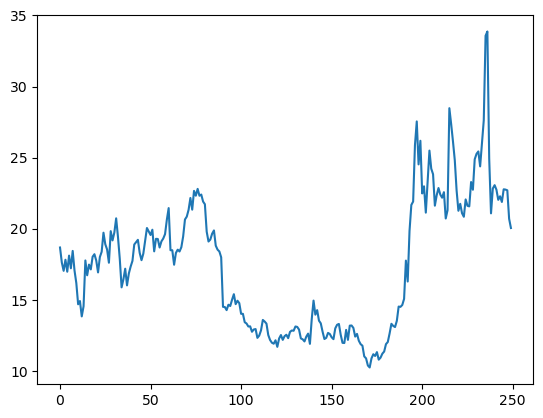

In [8]:
#Plot temp

plt.plot(df['Close'])
plt.show()

In [9]:
closePrice = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of closePrice
closePrice.shape

(250, 1)

## Transforming it to squence order of 10

In [10]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [11]:
closePrice = closePrice[row_count % sequence_length: ]
closePrice.shape

(250, 1)

In [12]:
closePrice = closePrice.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
closePrice

array([[18.690001, 17.629999, 17.049999, 17.83    , 16.99    , 18.120001,
        17.23    , 18.450001, 17.08    , 16.190001],
       [14.7     , 14.93    , 13.85    , 14.56    , 17.780001, 16.74    ,
        17.49    , 17.15    , 18.040001, 18.219999],
       [17.780001, 16.940001, 18.02    , 18.389999, 19.73    , 18.92    ,
        18.549999, 17.620001, 19.84    , 19.190001],
       [19.74    , 20.74    , 19.440001, 17.889999, 15.89    , 16.450001,
        17.200001, 16.030001, 16.860001, 17.35    ],
       [17.75    , 18.9     , 19.07    , 19.23    , 18.309999, 17.799999,
        18.26    , 19.15    , 20.059999, 19.809999],
       [19.57    , 19.940001, 18.42    , 19.299999, 19.290001, 18.690001,
        19.120001, 19.32    , 19.629999, 20.65    ],
       [21.459999, 18.5     , 18.5     , 17.48    , 18.309999, 18.540001,
        18.41    , 18.709999, 19.469999, 20.66    ],
       [20.860001, 21.34    , 22.17    , 21.35    , 22.67    , 22.33    ,
        22.809999, 22.33    , 22.41  

In [13]:
# we can now see that our days have been organized into rows of sequence length. 

In [14]:
# create our X and y. 
# X will be the 9 days prior...
X = closePrice[:, :-1] # all rows, all columns except the last one
# y will be the 10th day (what we are trying to predict)
y = closePrice[:, -1] # all rows, only the last column

## Train - test split 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(17, 9, 1)
(8, 9, 1)


## Create dataframe to store results    

We are running 8 models in this notebook. We will store the results in a dataframe for easy comparison.

In [17]:
df_results = pd.DataFrame({'model': [], 'time': [], 'RMSE': [], 'Predicted Close Price': []})

In [18]:
# write common functions to reduce repetation of code

def plot_graph(history, modelName): # function to plot the graph of loss and RMSE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(modelName)

    ax1.set_title('loss')
    #ax1.set_ylim(0, 100)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.set_title('RMSE')
    #ax2.set_ylim(0, 1)
    ax2.plot(history.history['root_mean_squared_error'])
    ax2.plot(history.history['val_root_mean_squared_error'])
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.show()

In [19]:
def plot_train_test_fit(y_pred):
    plt.figure(figsize=(15, 7))
    plt.title('fit_comparision')

    # Plot y_test and y_pred
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.legend(['test', 'train'])

    # Show the plot
    plt.show()

# Simple RNN

In [20]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(63, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 63)                4095      
                                                                 
 dense (Dense)               (None, 1)                 64        
                                                                 
Total params: 4,159
Trainable params: 4,159
Non-trainable params: 0
_________________________________________________________________


In [21]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800


2023-04-23 15:10:09.534099: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 555ms/step - loss: 315.3982 - root_mean_squared_error: 17.7595 - val_loss: 262.3242 - val_root_mean_squared_error: 16.1964
Epoch 2/800
1/1 [==============================] - 0s 13ms/step - loss: 311.2050 - root_mean_squared_error: 17.6410 - val_loss: 259.0518 - val_root_mean_squared_error: 16.0951
Epoch 3/800
1/1 [==============================] - 0s 15ms/step - loss: 307.7530 - root_mean_squared_error: 17.5429 - val_loss: 255.6450 - val_root_mean_squared_error: 15.9889
Epoch 4/800
1/1 [==============================] - 0s 14ms/step - loss: 304.1413 - root_mean_squared_error: 17.4396 - val_loss: 252.0839 - val_root_mean_squared_error: 15.8772
Epoch 5/800
1/1 [==============================] - 0s 16ms/step - loss: 300.3464 - root_mean_squared_error: 17.3305 - val_loss: 248.3609 - val_root_mean_squared_error: 15.7595
Epoch 6/800
1/1 [==============================] - 0s 14ms/step - loss: 296.3569 - root_mean_squared_error: 17.2150 - val_loss: 244

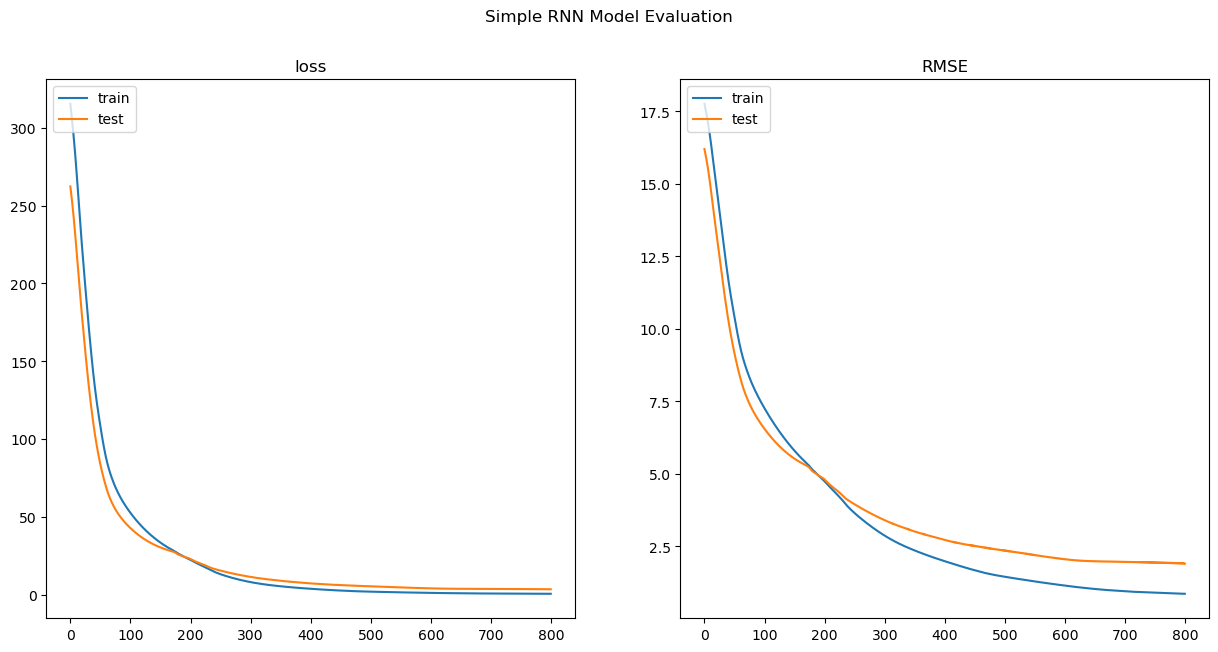

In [23]:
plot_graph(history,'Simple RNN Model Evaluation')

In [24]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 63ms/step


1.9051033462319136

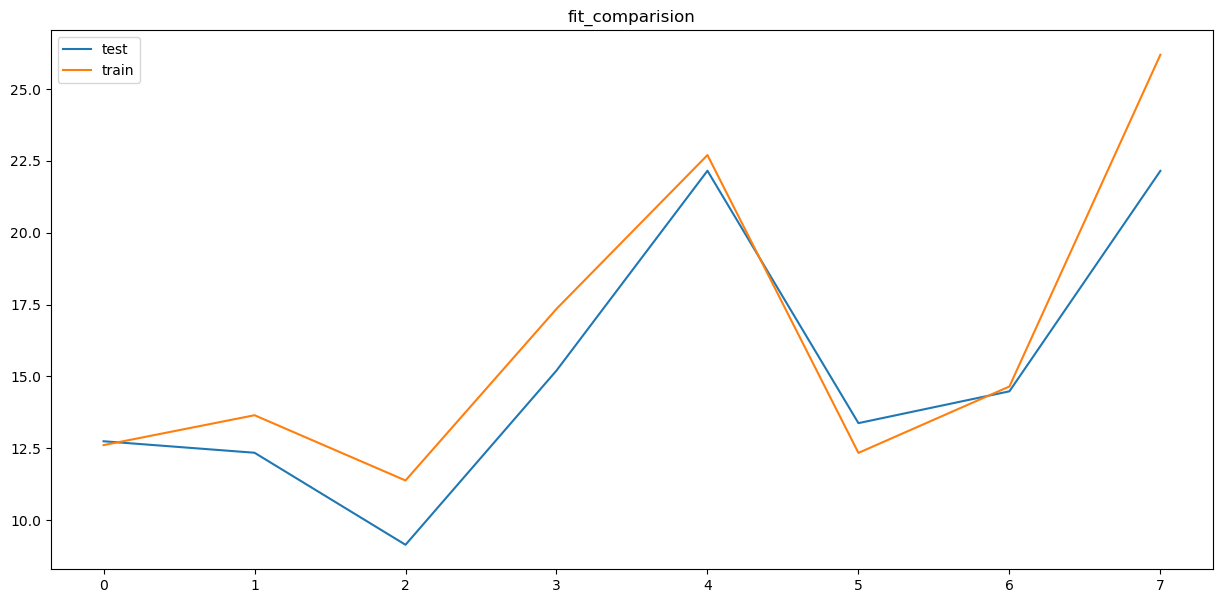

In [25]:
plot_train_test_fit(y_pred)

Now, let's set our past 9 days of close price were as follow....

In [26]:
last_set_closePrice = closePrice[-1] # geting the last set of sequence.
last_set_closePrice

array([23.07    , 22.75    , 22.040001, 22.290001, 21.889999, 22.780001,
       22.76    , 22.709999, 20.709999, 20.059999])

In [27]:
recent_9_price = last_set_closePrice[-9:] # as we are predicting the next day closing price, we have 10 closing price in the last set of row, and we are taking only the last 9 days closing price to predict the next day closing price.

# reshape into the three dimensions for input into model
prior_days = recent_9_price.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)
prior_days

array([[[22.75    ],
        [22.040001],
        [22.290001],
        [21.889999],
        [22.780001],
        [22.76    ],
        [22.709999],
        [20.709999],
        [20.059999]]])

In [28]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 9ms/step


21.6267

In [29]:
df_result = pd.DataFrame(
    {
        'model': ['Simple RNN'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# Deep RNN

In [30]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(63, return_sequences=True, input_shape=[n_steps, n_inputs] ),
    keras.layers.SimpleRNN(63, return_sequences=True),
    keras.layers.SimpleRNN(63), 
    keras.layers.Dense(1, activation=None)
])

In [31]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [32]:
start_time = time.time()

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
1/1 [==============================] - 1s 1s/step - loss: 330.4915 - root_mean_squared_error: 18.1794 - val_loss: 255.6230 - val_root_mean_squared_error: 15.9882
Epoch 2/800
1/1 [==============================] - 0s 19ms/step - loss: 303.9054 - root_mean_squared_error: 17.4329 - val_loss: 238.8992 - val_root_mean_squared_error: 15.4564
Epoch 3/800
1/1 [==============================] - 0s 18ms/step - loss: 284.6492 - root_mean_squared_error: 16.8715 - val_loss: 225.6620 - val_root_mean_squared_error: 15.0221
Epoch 4/800
1/1 [==============================] - 0s 18ms/step - loss: 269.6645 - root_mean_squared_error: 16.4215 - val_loss: 214.9843 - val_root_mean_squared_error: 14.6623
Epoch 5/800
1/1 [==============================] - 0s 18ms/step - loss: 257.6386 - root_mean_squared_error: 16.0511 - val_loss: 205.3063 - val_root_mean_squared_error: 14.3285
Epoch 6/800
1/1 [==============================] - 0s 19ms/step - loss: 246.7771 - root_mean_squared_error: 15.7091 - val_

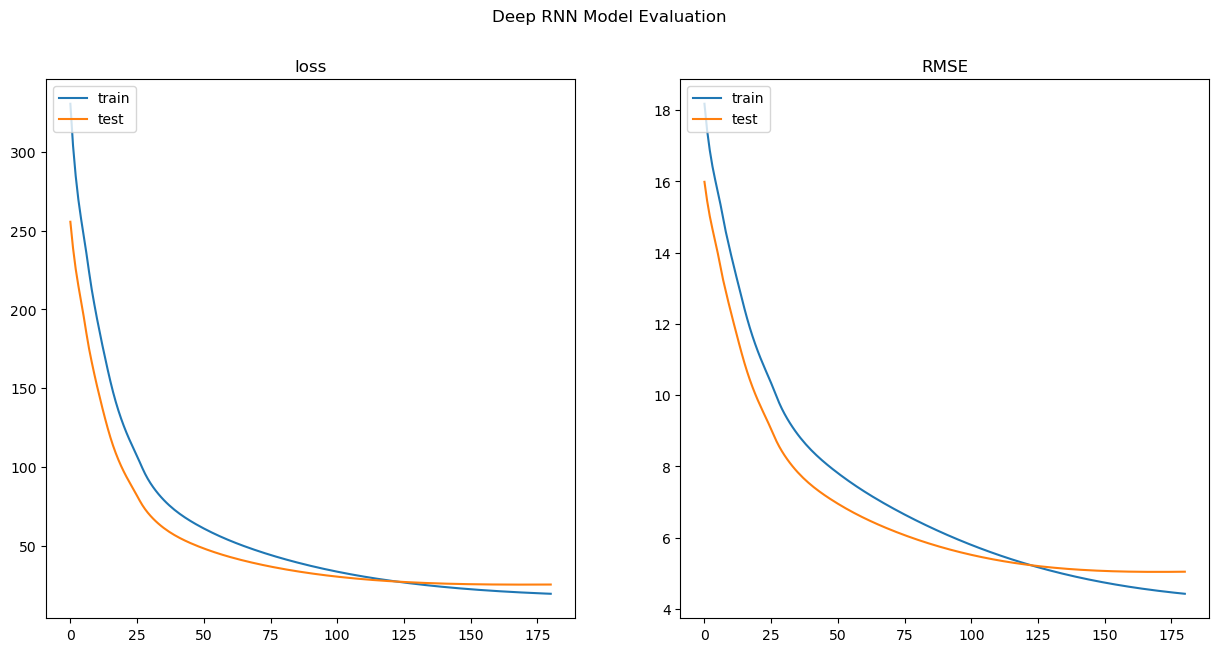

In [33]:
plot_graph(history,'Deep RNN Model Evaluation')

In [34]:
y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 114ms/step


5.042880904217954

Now, let's set our past 9 days of close price were as follow....

In [35]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 10ms/step


16.585861

In [36]:
df_result = pd.DataFrame(
    {
        'model': ['Deep RNN'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# LSTM with one layer

In [37]:
model = keras.models.Sequential([
    keras.layers.LSTM(63, input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation=None)
])

In [38]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [39]:
start_time = time.time()

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
1/1 [==============================] - 1s 1s/step - loss: 334.9451 - root_mean_squared_error: 18.3015 - val_loss: 278.5882 - val_root_mean_squared_error: 16.6910
Epoch 2/800
1/1 [==============================] - 0s 21ms/step - loss: 329.0516 - root_mean_squared_error: 18.1398 - val_loss: 274.8285 - val_root_mean_squared_error: 16.5780
Epoch 3/800
1/1 [==============================] - 0s 17ms/step - loss: 324.9584 - root_mean_squared_error: 18.0266 - val_loss: 270.9762 - val_root_mean_squared_error: 16.4614
Epoch 4/800
1/1 [==============================] - 0s 17ms/step - loss: 320.7631 - root_mean_squared_error: 17.9099 - val_loss: 267.0186 - val_root_mean_squared_error: 16.3407
Epoch 5/800
1/1 [==============================] - 0s 19ms/step - loss: 316.4460 - root_mean_squared_error: 17.7889 - val_loss: 262.9656 - val_root_mean_squared_error: 16.2162
Epoch 6/800
1/1 [==============================] - 0s 29ms/step - loss: 312.0107 - root_mean_squared_error: 17.6638 - val_

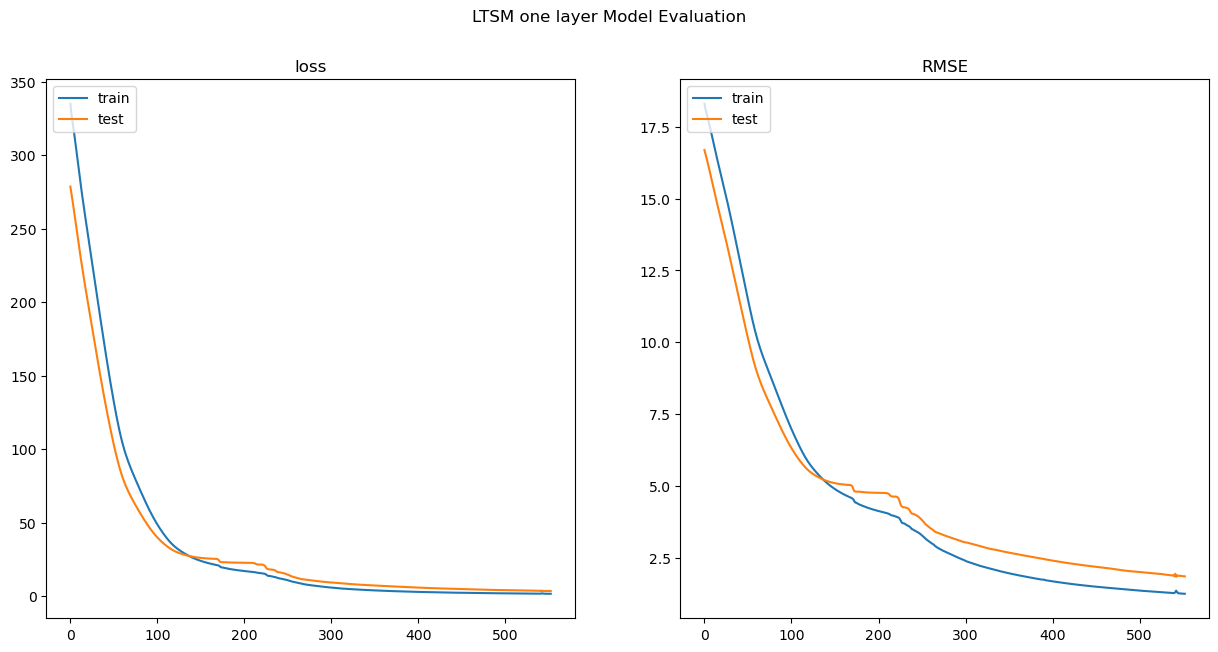

In [40]:
plot_graph(history,'LTSM one layer Model Evaluation')

In [41]:
y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 139ms/step


1.8512335721674167

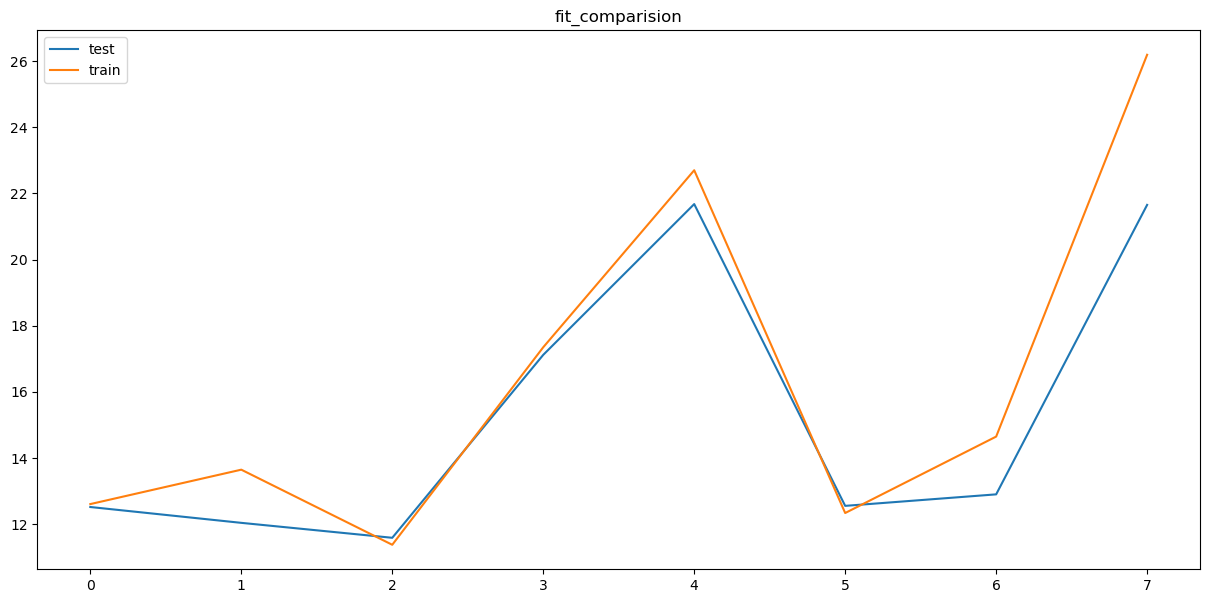

In [42]:
plot_train_test_fit(y_pred)

Now, let's set our past 9 days of close price were as follow....

In [43]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 10ms/step


21.426775

In [44]:
df_result = pd.DataFrame(
    {
        'model': ['LTSM one layer'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# LSTM with more layers

In [45]:
model = keras.models.Sequential([
    keras.layers.LSTM(63, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.LSTM(63, return_sequences=True),
    keras.layers.LSTM(63),
    keras.layers.Dense(1, activation=None)
])

In [46]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [47]:
start_time = time.time()

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
1/1 [==============================] - 2s 2s/step - loss: 345.2731 - root_mean_squared_error: 18.5815 - val_loss: 287.4374 - val_root_mean_squared_error: 16.9540
Epoch 2/800
1/1 [==============================] - 0s 27ms/step - loss: 339.8850 - root_mean_squared_error: 18.4360 - val_loss: 282.6574 - val_root_mean_squared_error: 16.8124
Epoch 3/800
1/1 [==============================] - 0s 23ms/step - loss: 334.5170 - root_mean_squared_error: 18.2898 - val_loss: 277.2496 - val_root_mean_squared_error: 16.6508
Epoch 4/800
1/1 [==============================] - 0s 23ms/step - loss: 328.4340 - root_mean_squared_error: 18.1227 - val_loss: 270.9115 - val_root_mean_squared_error: 16.4594
Epoch 5/800
1/1 [==============================] - 0s 23ms/step - loss: 321.2991 - root_mean_squared_error: 17.9248 - val_loss: 263.2721 - val_root_mean_squared_error: 16.2257
Epoch 6/800
1/1 [==============================] - 0s 23ms/step - loss: 312.7021 - root_mean_squared_error: 17.6834 - val_

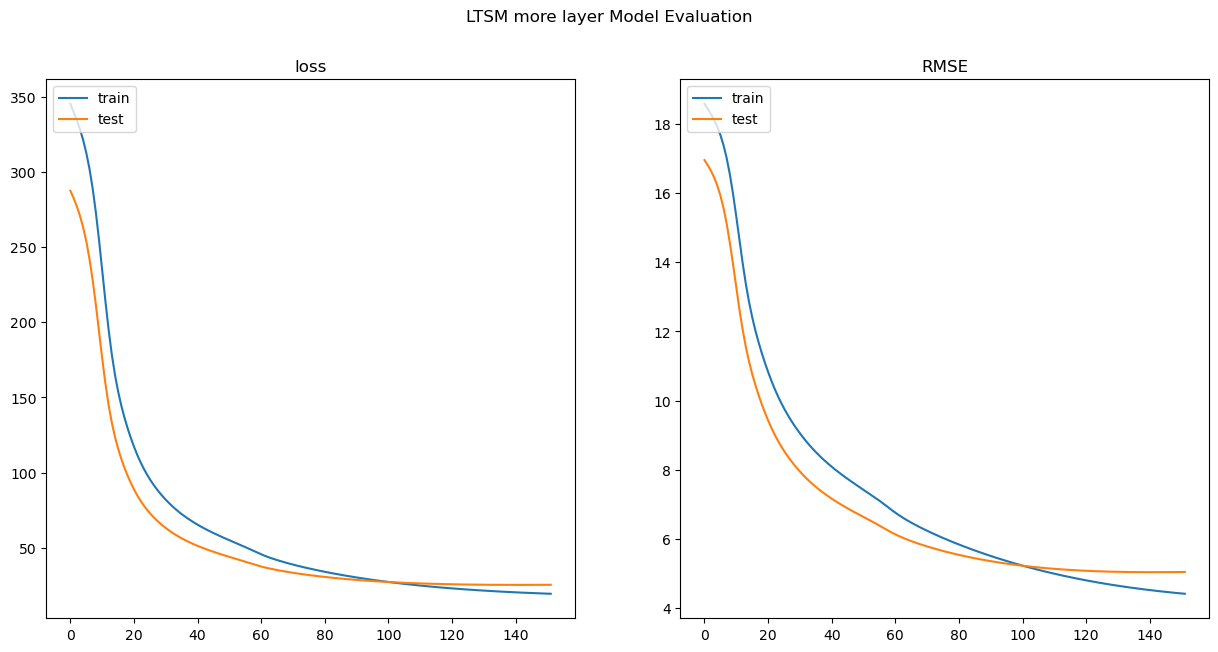

In [48]:
plot_graph(history,'LTSM more layer Model Evaluation')

In [49]:
y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 326ms/step


5.045473703858356

Now, let's set our past 9 days of close price were as follow....

In [50]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 10ms/step


16.616596

In [51]:
df_result = pd.DataFrame(
    {
        'model': ['LTSM more layer'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# GRU with one layer

In [52]:
model = keras.models.Sequential([
    keras.layers.GRU(63, input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation=None)
])

In [53]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [54]:
start_time = time.time()

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
1/1 [==============================] - 1s 868ms/step - loss: 343.6029 - root_mean_squared_error: 18.5365 - val_loss: 284.4676 - val_root_mean_squared_error: 16.8662
Epoch 2/800
1/1 [==============================] - 0s 16ms/step - loss: 337.9161 - root_mean_squared_error: 18.3825 - val_loss: 280.4863 - val_root_mean_squared_error: 16.7477
Epoch 3/800
1/1 [==============================] - 0s 17ms/step - loss: 333.5760 - root_mean_squared_error: 18.2641 - val_loss: 276.3492 - val_root_mean_squared_error: 16.6238
Epoch 4/800
1/1 [==============================] - 0s 17ms/step - loss: 329.0592 - root_mean_squared_error: 18.1400 - val_loss: 272.0445 - val_root_mean_squared_error: 16.4938
Epoch 5/800
1/1 [==============================] - 0s 17ms/step - loss: 324.3512 - root_mean_squared_error: 18.0098 - val_loss: 267.5809 - val_root_mean_squared_error: 16.3579
Epoch 6/800
1/1 [==============================] - 0s 16ms/step - loss: 319.4612 - root_mean_squared_error: 17.8735 - v

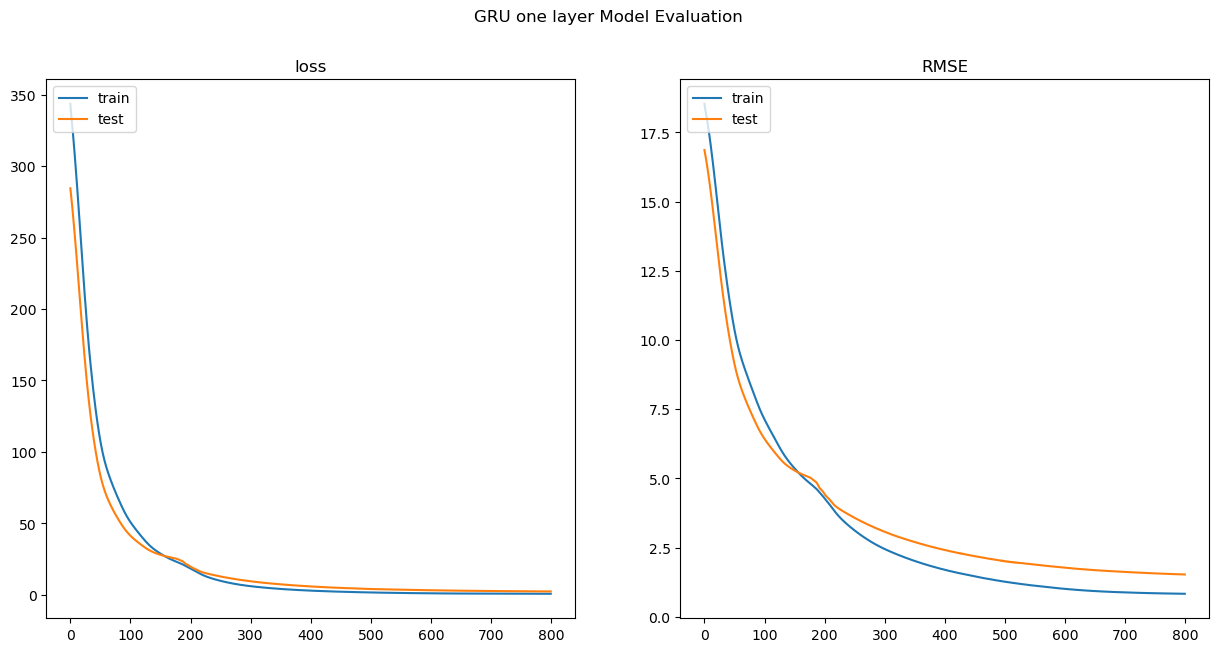

In [55]:
plot_graph(history,'GRU one layer Model Evaluation')

In [56]:
y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 150ms/step


1.5324643949579597

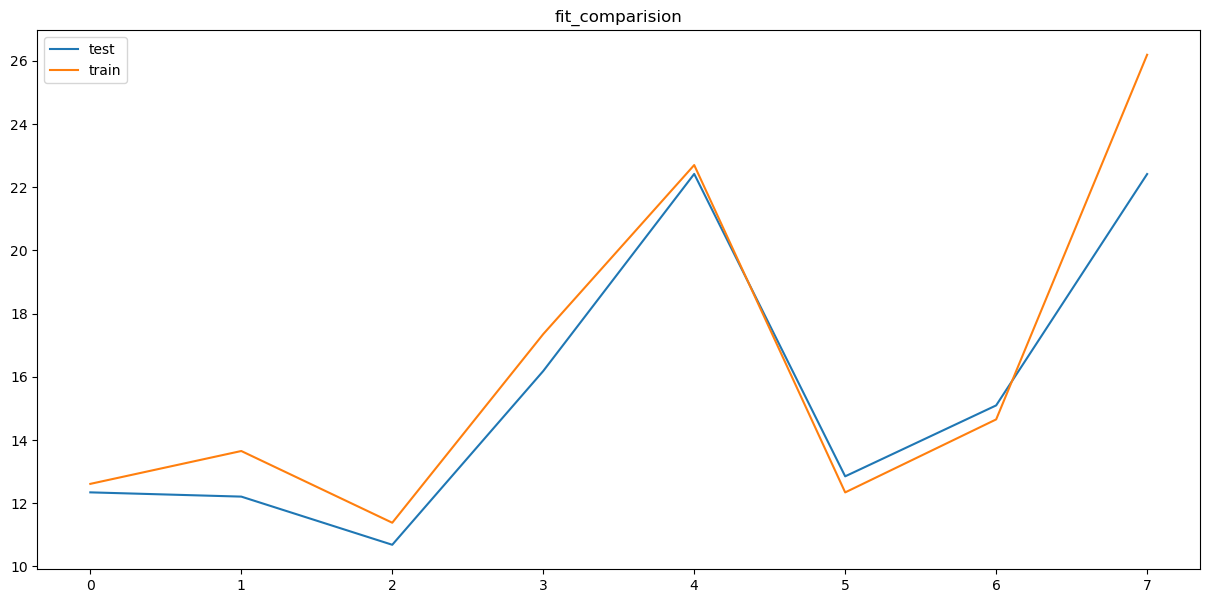

In [57]:
plot_train_test_fit(y_pred)

Now, let's set our past 9 days of close price were as follow....

In [58]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 9ms/step


21.581322

In [59]:
df_result = pd.DataFrame(
    {
        'model': ['GRU one layer'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# GRU with more layers

In [60]:
model = keras.models.Sequential([
    keras.layers.GRU(63, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.GRU(63, return_sequences=True),
    keras.layers.GRU(63),
    keras.layers.Dense(1, activation=None)
])

In [61]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [62]:
start_time = time.time()

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
1/1 [==============================] - 3s 3s/step - loss: 328.0483 - root_mean_squared_error: 18.1121 - val_loss: 263.6818 - val_root_mean_squared_error: 16.2383
Epoch 2/800
1/1 [==============================] - 0s 26ms/step - loss: 312.0112 - root_mean_squared_error: 17.6638 - val_loss: 249.8772 - val_root_mean_squared_error: 15.8075
Epoch 3/800
1/1 [==============================] - 0s 26ms/step - loss: 296.7468 - root_mean_squared_error: 17.2263 - val_loss: 236.0340 - val_root_mean_squared_error: 15.3634
Epoch 4/800
1/1 [==============================] - 0s 25ms/step - loss: 281.3935 - root_mean_squared_error: 16.7748 - val_loss: 222.2219 - val_root_mean_squared_error: 14.9071
Epoch 5/800
1/1 [==============================] - 0s 25ms/step - loss: 266.0191 - root_mean_squared_error: 16.3101 - val_loss: 208.5047 - val_root_mean_squared_error: 14.4397
Epoch 6/800
1/1 [==============================] - 0s 25ms/step - loss: 250.6840 - root_mean_squared_error: 15.8330 - val_

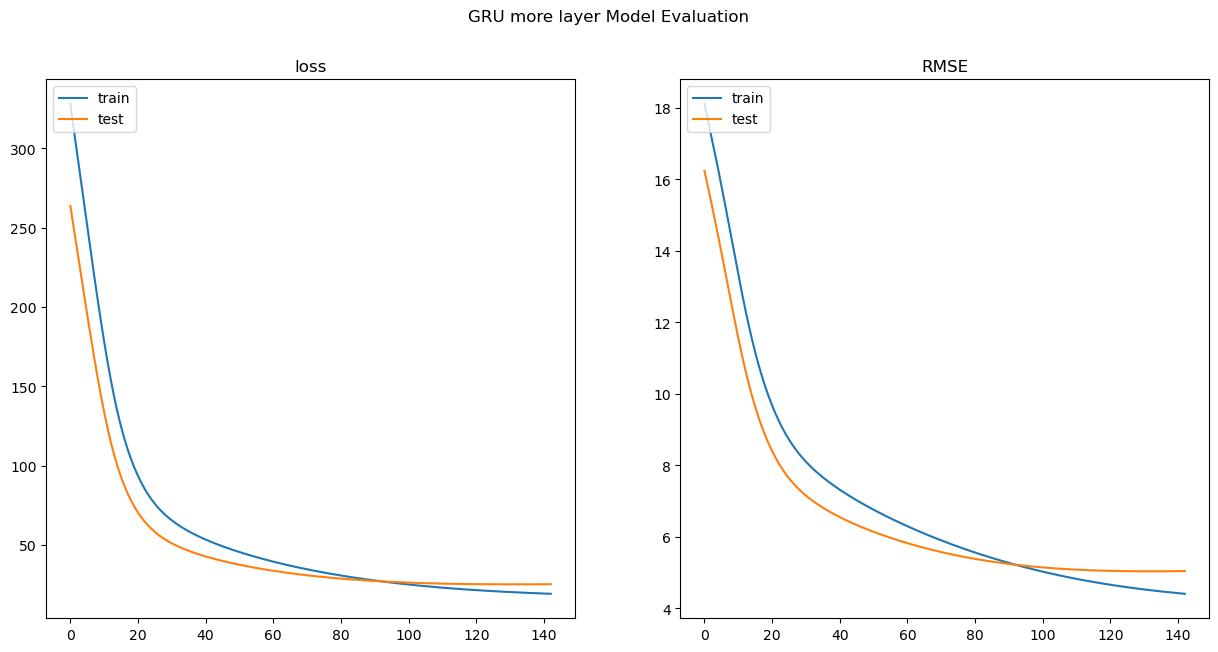

In [63]:
plot_graph(history,'GRU more layer Model Evaluation')

In [64]:
y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 301ms/step


5.045889766133927

Now, let's set our past 9 days of close price were as follow....

In [65]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 11ms/step


16.627794

In [66]:
df_result = pd.DataFrame(
    {
        'model': ['GRU more layer'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# Conv1D

In [67]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=3, strides=2, padding="valid", input_shape=[n_steps, n_inputs]),
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=2, padding="valid"),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation=None)
])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 10)             40        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 20)             620       
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,797
Trainable params: 15,797
Non-trainable params: 0
_________________________________________________________________


In [68]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [69]:
start_time = time.time()

history = model.fit(
    X_train, 
    y_train, 
    epochs=800,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
1/1 [==============================] - 2s 2s/step - loss: 349.6884 - root_mean_squared_error: 18.7000 - val_loss: 295.7133 - val_root_mean_squared_error: 17.1963
Epoch 2/800
1/1 [==============================] - 0s 14ms/step - loss: 348.8259 - root_mean_squared_error: 18.6769 - val_loss: 294.9557 - val_root_mean_squared_error: 17.1743
Epoch 3/800
1/1 [==============================] - 0s 16ms/step - loss: 347.9450 - root_mean_squared_error: 18.6533 - val_loss: 294.1555 - val_root_mean_squared_error: 17.1510
Epoch 4/800
1/1 [==============================] - 0s 16ms/step - loss: 347.0115 - root_mean_squared_error: 18.6282 - val_loss: 293.3223 - val_root_mean_squared_error: 17.1267
Epoch 5/800
1/1 [==============================] - 0s 15ms/step - loss: 346.0422 - root_mean_squared_error: 18.6022 - val_loss: 292.4698 - val_root_mean_squared_error: 17.1017
Epoch 6/800
1/1 [==============================] - 0s 15ms/step - loss: 345.0579 - root_mean_squared_error: 18.5757 - val_

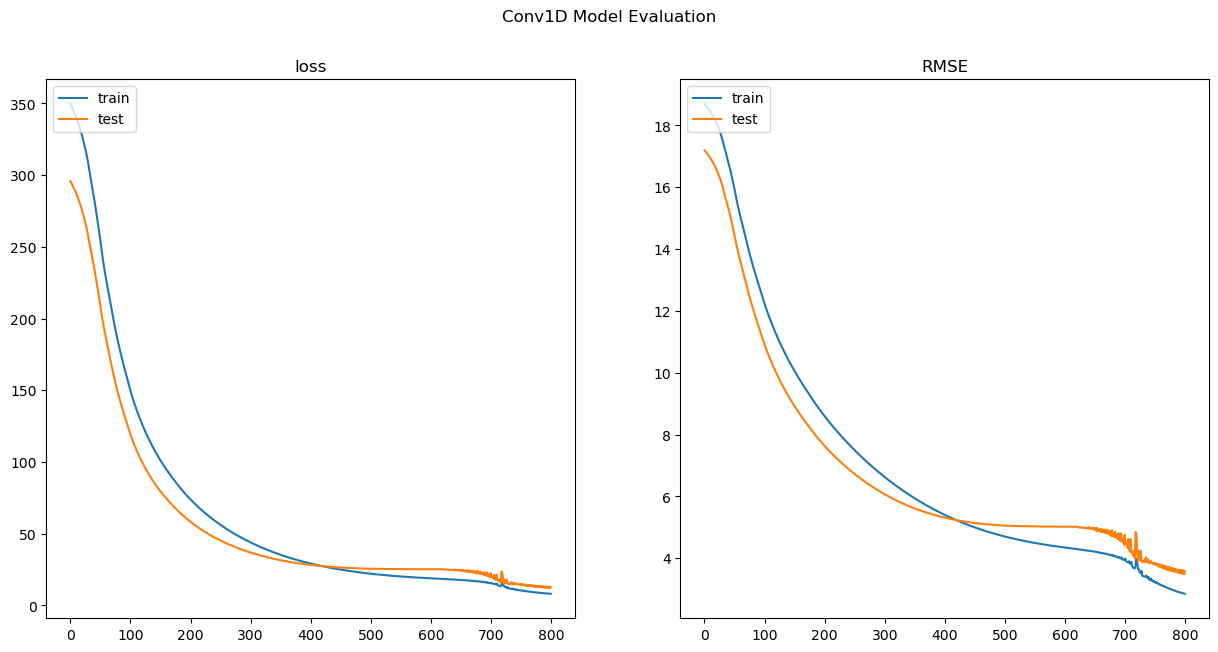

In [70]:
plot_graph(history,'Conv1D Model Evaluation')

In [71]:
y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

error_val = mean_squared_error(y_test, y_pred)**0.5
error_val

1/1 [==============================] - 0s 250ms/step


3.5798805504393187

Now, let's set our past 9 days of close price were as follow....

In [72]:
nextday_close_price = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions
nextday_close_price

1/1 [==============================] - 0s 9ms/step


18.225203

In [73]:
df_result = pd.DataFrame(
    {
        'model': ['Conv1D layer'], 
        'time': [end_time - start_time],
        'RMSE': [error_val], 
        'Predicted Close Price': [nextday_close_price]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## Summary of results

In [74]:
df_results.sort_values(by=['RMSE', 'time'], ascending=False)

,model,time,RMSE,Predicted Close Price
5,GRU more layer,5.533425,5.045890,16.627794
3,LTSM more layer,5.460259,5.045474,16.616596
1,Deep RNN,4.260671,5.042881,16.585861
6,Conv1D layer,13.875000,3.579881,18.225203
0,Simple RNN,12.151600,1.905103,21.626699
2,LTSM one layer,10.000293,1.851234,21.426775
4,GRU one layer,13.247263,1.532464,21.581322


From the above list of model comparision table, and the root mean square value to compre the best model for this stock price prediction is GRU with single layer.  It gives the lowest RMSE value. this shows that this model fits the values more closly and predicts the more close value to the next day closing value. <br>
GRU with more layer performed the least with a RMSE value of 5.0, which is not good.
LTSM with multi layer also has similar RMSE value and performs poor 
Deep RNN has similar RMSE value to the above two models, but still its poor with prediction
All these models take less time around 5-6 sec to train and fix models, wehereas the other models tool long time to train and gives better results.

Simple RNN, GRU single layer and LTSM with single layer modesl took long time to train and fit but they performed better than the other models. and gives a close result to the predicted value.

Overall GRU with single layer model gives the best fit for the closing price stock prediction 

### We are expecting the next day target value of the c3.ai will be 21.58 